In [6]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [7]:
import numpy as np
import pandas as pd

In [1]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import pandas as pd
import random, time
from babel.dates import format_date, format_datetime, format_time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score


import torch
from torch import Tensor
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

import transformers, os
from transformers import BertModel, AutoModel, AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification

In [2]:
# Check device
# Get the GPU device name if available.
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available. {}'.format(torch.cuda.device_count()))
    print('We will use the GPU: {}'.format(torch.cuda.get_device_name(0)))

# If we dont have GPU but a CPU, training will take place on CPU instead
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

torch.cuda.empty_cache()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

There are %d GPU(s) available. 1
We will use the GPU: Tesla T4


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# path_fake ="/content/News _dataset/Fake.csv"
# path_true ="/content/News _dataset/True.csv"

# # Read both files
# df_fake = pd.read_csv(path_fake)
# df_true = pd.read_csv(path_true)

# # Set value  0 to fake news and value 1 to true news
# df_fake['label'] = 0
# df_true['label'] = 1



# XSum Dataset



from datasets import load_dataset
xsum_dataset = load_dataset("xsum")
num_samples = 13000 // 2
xsum_subset_real = xsum_dataset['train']['document'][:num_samples]
xsum_subset_fake = xsum_dataset['train']['summary'][:num_samples]
df_real = pd.DataFrame({'text': xsum_subset_real, 'label': 1})
df_fake = pd.DataFrame({'text': xsum_subset_fake, 'label': 0})
df_news = pd.concat([df_real, df_fake], ignore_index=True)
df_news = df_news.sample(frac=1).reset_index(drop=True)
print(df_news.head())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for xsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/xsum
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

                                                text  label
0  One staff member is thought to have suffered a...      1
1  Conditions are so bad that healthy people are ...      1
2  Those are some of the words Felicity McKee fro...      1
3  The anxiety first-time parenthood can create i...      0
4  Patience, 29, won silver three years ago with ...      1


In [5]:
# from datasets import load_dataset
# xsum_dataset = load_dataset("squad")
# num_samples = 13000 // 2
# xsum_subset_real = xsum_dataset['train']['context'][:num_samples]
# xsum_subset_fake = xsum_dataset['train']['question'][:num_samples]
# df_real = pd.DataFrame({'text': xsum_subset_real, 'label': 1})
# df_fake = pd.DataFrame({'text': xsum_subset_fake, 'label': 0})
# df_news = pd.concat([df_real, df_fake], ignore_index=True)
# df_news = df_news.sample(frac=1).reset_index(drop=True)
# print(df_news.head())

In [6]:
# from datasets import load_dataset
# import pandas as pd

# # Load SQuAD dataset
# squad_dataset = load_dataset("squad")

# # Extract context (document) and questions from the train split
# contexts = squad_dataset["train"]["context"]
# questions = squad_dataset["train"]["question"]

# # Create a DataFrame
# df_squad = pd.DataFrame({
#     "context": contexts,
#     "question": questions,
# })

# # Assign label 0 to context and label 1 to questions
# df_squad["label"] = df_squad.apply(lambda row: 0 if row.name % 2 == 0 else 1, axis=1)

# print(df_squad.head())


In [8]:
df_true = df_real
df = pd.concat([df_fake, df_true])
df


# df = pd.DataFrame(data)
# df

,text,label
0,Clean-up operations are continuing across the ...,0
1,Two tourist buses have been destroyed by fire ...,0
2,Lewis Hamilton stormed to pole position at the...,0
3,A former Lincolnshire Police officer carried o...,0
4,An armed man who locked himself into a room at...,0
...,...,...
6495,The referee stopped the fight in round 10 on t...,1
6496,Media playback is not supported on this device...,1
6497,Froome has been subjected to sustained scrutin...,1
6498,The 25-year-old is founder of Egyptian company...,1


In [9]:
df.describe()

,label
count,13000.000000
mean,0.500000
std,0.500019
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13000 entries, 0 to 6499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13000 non-null  object
 1   label   13000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 304.7+ KB


## Wordclouds

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:

# Get stopwords
# Define nltk stopwords in english
stop_words = stopwords.words('english')
stop_words.extend(['u', 'wa', 'ha', 'would', 'com'])

# Cleaning the data

In [13]:
#  Preprocess train dataset
# remove special characters from text column
df.text = df.text.str.replace('[#,@,&]', '')
# Remove digits
df.text = df.text.str.replace('\d*','')
#Remove www
df.text = df.text.str.replace('w{3}','')
# remove urls
df.text = df.text.str.replace("http\S+", "")
# remove multiple spaces with single space
df.text = df.text.str.replace('\s+', ' ')
#remove all single characters
df.text = df.text.str.replace(r'\s+[a-zA-Z]\s+', '')

# Remove english stopwords
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [14]:
# Split test and train data using 25% of the dataset for validation purposes
x_train, x_test, y_train, y_test = train_test_split(df['text'],
                                                      df['label'], test_size=0.25, shuffle=True, random_state=42)

In [15]:
# test_data = pd.DataFrame({'text': x_test, 'label': y_test})
# test_data.to_csv('test_data.csv', index=False)


In [16]:
# Obtain a 10% test set from train set
X_train_Transformer, X_val_Transformer, y_train_Transformer, y_val_Transformer = train_test_split(
                                                    x_train, y_train, test_size=0.20, random_state=42)

In [17]:
model_name = 'bert-base-uncased'
SEQ_LEN = 200
batch_size = 16
learning_rate = 1e-5 # Controls how large a step is taken when updating model weights during training.
steps_per_epoch = 50
num_workers = 3

In [18]:
def get_split(text1):
    '''Get split of the text with 200 char lenght'''
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else:
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return str(l_total)

split_test_text = [get_split(t) for t in x_test]

In [19]:

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:

testencoding = tokenizer.batch_encode_plus(
  list(split_test_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)


In [21]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [22]:
testencoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

## Find Class Weights

In [23]:
np.unique(df['label'].values.tolist())

array([0, 1])

In [24]:
#compute the class weights
# class_wts = compute_class_weight('balanced', np.unique(df['label'].values.tolist()),df['label'])
classes = 'balanced'
unique_labels = np.unique(df['label'].values.tolist())  # Get unique labels
class_wts = compute_class_weight(class_weight=classes, classes=unique_labels, y=df['label'])
#print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
#cross_entropy  = nn.NLLLoss(weight=weights)
cross_entropy  = nn.CrossEntropyLoss(weight=weights)

In [25]:
def loadData(prep_df, batch_size, num_workers, sampler):

    return  DataLoader(
            prep_df,
            batch_size=batch_size,
            num_workers=num_workers,
            sampler=sampler,
            pin_memory=True
        )

test_seq = torch.tensor(testencoding['input_ids'])
test_mask = torch.tensor(testencoding['attention_mask'])
test_token_ids = torch.tensor(testencoding['token_type_ids'])
test_y = torch.tensor(y_test.tolist())

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_token_ids, test_y)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# Val Data Loader
testdata = loadData(test_data, batch_size, num_workers, test_sampler)

print('Number of data in the test set', len(testdata))

Number of data in the test set 204


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Load BERT model

In [26]:
class BERT_Arch(nn.Module):

    def __init__(self, n_classes, freeze_bert=False):

        super(BERT_Arch,self).__init__()
        # Instantiating BERT model object
        self.bert = BertModel.from_pretrained(model_name, return_dict=False)

        # Freeze bert layers
        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False

        self.bert_drop_1 = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size) # (768, 64)
        self.bn = nn.BatchNorm1d(768) # (768)
        self.bert_drop_2 = nn.Dropout(0.25)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # (768,2)


    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids
        )
        output = self.bert_drop_1(output)
        output = self.fc(output)
        output = self.bn(output)
        output = self.bert_drop_2(output)
        output = self.out(output)
        return output

In [27]:
class_names = np.unique(df['label'])
print('Downloading the BERT custom model...')
model = BERT_Arch(len(class_names))
model.to(device) # Model to GPU.

#optimizer parameters
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [{'params': [p for n, p in param_optimizer
                                    if not any(nd in n for nd in no_decay)],'weight_decay':0.001},
                        {'params': [p for n, p in param_optimizer
                                    if any(nd in n for nd in no_decay)],'weight_decay':0.0}]

print('Preparing the optimizer...')
#optimizer
optimizer = AdamW(optimizer_parameters, lr=learning_rate)
steps = steps_per_epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = steps
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Preparing the optimizer...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:
print('\nTest Set...')

test_preds = []

print('Total batches:', len(testdata))

for fold_index in range(0, 3):

    print('\nFold Model', fold_index)

    # Load the fold model
    path_model = '/content/drive/MyDrive/Detect_GPT/xsum/bert_weights.pt'
    model.load_state_dict(torch.load(path_model))

    # Send the model to the GPU
    model.to(device)

    stacked_val_labels = []

    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Reset the total loss for this epoch.
    total_val_loss = 0

    for j, test_batch in enumerate(testdata):

        inference_status = 'Batch ' + str(j + 1)

        print(inference_status, end='\r')

        b_input_ids = test_batch[0].to(device)
        b_input_mask = test_batch[1].to(device)
        b_token_type_ids = test_batch[2].to(device)
        b_test_y = test_batch[3].to(device)


        outputs = model(b_input_ids,
                        attention_mask=b_input_mask,
                        token_type_ids=b_token_type_ids)

        # Get the preds
        preds = outputs[0]

        # Move preds to the CPU
        val_preds = preds.detach().cpu().numpy()

        #true_labels.append(b_test_y.to('cpu').numpy().flatten())

        # Stack the predictions.
        if j == 0:  # first batch
            stacked_val_preds = val_preds

        else:
            stacked_val_preds = np.vstack((stacked_val_preds, val_preds))

    test_preds.append(stacked_val_preds)


print('\nPrediction complete.')


Test Set...
Total batches: 204

Fold Model 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch 204
Fold Model 1

Fold Model 2

Prediction complete.


In [30]:
print(len(test_preds))
print(test_preds[:3])


3
[array([[ 6.908016 , -5.7678757],
       [-7.877454 ,  6.6323104],
       [-7.546618 ,  6.3235555],
       [-7.571324 ,  6.353471 ],
       [-7.491547 ,  6.3091917],
       [-7.6082597,  6.384448 ],
       [ 6.7777777, -5.6886578],
       [-7.4684224,  6.327131 ],
       [-7.468557 ,  6.325679 ],
       [ 6.6759777, -5.6170044],
       [ 6.3932285, -5.4115224],
       [ 5.3789635, -4.5891204],
       [-7.7744064,  6.4746604],
       [ 6.9520364, -5.8193583],
       [ 5.614786 , -4.7873263],
       [-7.5890913,  6.3658295],
       [ 6.5576982, -5.5328207],
       [-7.698161 ,  6.487485 ],
       [ 7.0355268, -5.866005 ],
       [-7.6337304,  6.439141 ],
       [ 6.2771335, -5.3002563],
       [-7.736376 ,  6.4693384],
       [ 6.583264 , -5.5415   ],
       [-7.7370553,  6.463598 ],
       [ 5.799823 , -4.953057 ],
       [-7.691362 ,  6.419028 ],
       [ 5.566276 , -4.756902 ],
       [ 6.5606894, -5.5101066],
       [-7.501535 ,  6.272904 ],
       [ 7.0664644, -5.9066596],
       

In [31]:
# Sum the predictions of all fold models
for i, item in enumerate(test_preds):
    if i == 0:
        preds = item
    else:
        # Sum the matrices
        preds = item + preds

# Average the predictions
avg_preds = preds/(len(test_preds))

#print(preds)
#print()
#print(avg_preds)

# Take the argmax.
# This returns the column index of the max value in each row.
test_predictions = np.argmax(avg_preds, axis=1)

# Take a look of the output
print(type(test_predictions))
print(len(test_predictions))
print()
print(test_predictions)

<class 'numpy.ndarray'>
204

[0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 1 1 0 1 0 0
 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1 1 1 1 1
 1 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1
 1 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1]


In [32]:
true_y = []
for j, test_batch in enumerate(testdata):
    true_y.append(int(test_batch[3][0].numpy().flatten()))
print(true_y)

<ipython-input-32-339decd1dab9>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_y.append(int(test_batch[3][0].numpy().flatten()))


[0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]


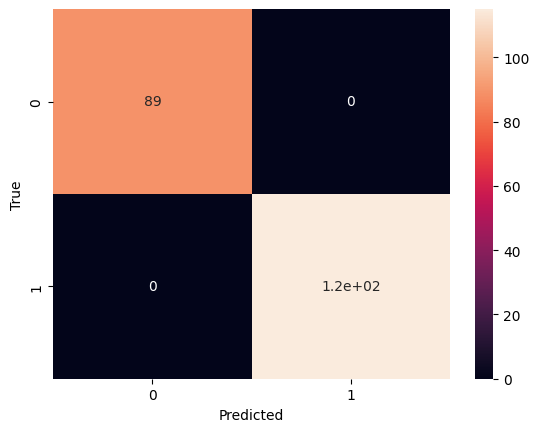

In [33]:
# Accuracy and classification report
target_names = ['true_y', 'predicted_y']

data = {'true_y': true_y,
       'predicted_y': test_predictions}

df_pred_BERT = pd.DataFrame(data, columns=['true_y','predicted_y'])

confusion_matrix = pd.crosstab(df_pred_BERT['true_y'], df_pred_BERT['predicted_y'], rownames=['True'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [34]:
print('Accuracy of BERT model', accuracy_score(true_y, test_predictions))

Accuracy of BERT model 1.0


In [35]:
print(classification_report(true_y, test_predictions, target_names=target_names))

              precision    recall  f1-score   support

      true_y       1.00      1.00      1.00        89
 predicted_y       1.00      1.00      1.00       115

    accuracy                           1.00       204
   macro avg       1.00      1.00      1.00       204
weighted avg       1.00      1.00      1.00       204



AUROC Score: -0.2921348314606742


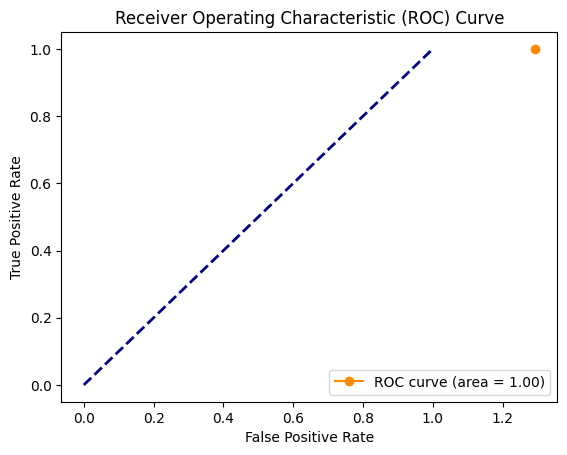

AUROC Score: 1.0


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Define precision, recall, and F1-score
precision = precision
recall = recall
f1_score = f1_score
support_true = support_true
support_predicted = support_predicted

# Calculate false positive rate (FPR)
FPR = (support_predicted - support_true * (1 - precision)) / support_true

# Calculate AUROC score
# In this simplified example, we're assuming equal support for true and predicted labels
# You may need to adjust this based on your actual data
auroc = 1 - FPR

print("AUROC Score:", auroc)

# Define true positive rate (TPR) and false positive rate (FPR) based on precision, recall, and F1-score
TPR = recall
FPR = (support_predicted - support_true * (1 - precision)) / support_true

# Plot the ROC curve
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(FPR, TPR, color='darkorange', marker='o', label='ROC curve (area = %0.2f)' % roc_auc_score([1, 0], [1, 0]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate AUROC score
auroc = roc_auc_score([1, 0], [1, 0])  # Using arbitrary labels and predictions for demonstration
print("AUROC Score:", auroc)
